In [40]:
import glob
import pandas as pd

%matplotlib inline

In [89]:
def fill_pushers(df, DATA, num_samples, sample_interval):
    pushers = glob.glob('%s/push_*.txt'%DATA)
    
    for fname in pushers:
        row=1

        push_ind = int(fname.split('/')[3].strip().split('_')[1])
        #print push_ind
        f = open(fname,'r')
        times = f.readlines()
        
        #print len(times)
        f.close()    
                
        start_time = float(times[0].split(' ')[0].strip())
        
        #print times[0]
        cnt=1
    
        for val in times[1:]:

            cur_time = float(val.split(' ')[0].strip())
            cnt+=1

            if (cnt%sample_interval == 0)and(row<=num_samples):
                #print 'Throughput: %s'%(float(cnt/(cur_time-start_time)))
                df.loc[row*sample_interval]['Push_proc_%s'%push_ind] = float(cnt/(cur_time-start_time))
                row+=1
    #print df
    return df

In [90]:
def fill_poppers(df, DATA, num_samples, sample_interval):
    poppers = glob.glob('%s/pop_*.txt'%DATA)

    for fname in poppers:
        row=1

        pop_ind = int(fname.split('/')[3].strip().split('_')[1])
        #print pop_ind
        f = open(fname,'r')
        times = f.readlines()

        start_time = float(times[0].split(' ')[0].strip())
        #print times[0]
        cnt=1
    
        for val in times[1:]:

            cur_time = float(val.split(' ')[0].strip())
            cnt+=1

            if (cnt%sample_interval == 0)and(row<=num_samples):
                #print '%s: Throughput: %s'%(nme, float(cnt/(cur_time-start_time)))
                df.loc[row*sample_interval]['Pop_proc_%s'%pop_ind] = float(cnt/(cur_time-start_time))
                row+=1
            
    #print df
    return df

In [91]:
def get_throughput_plot(num_push_procs, num_pop_procs, num_queues, num_samples):

    push_cols_avg = ['Push_proc_%s'%i for i in range(num_push_procs)]
    #push_cols_err = ['Push_proc_%s'%i for i in range(num_push_procs)]
    pop_cols_avg = ['Pop_proc_%s'%i for i in range(num_pop_procs)]
    #pop_cols_err = ['Pop_proc_%s'%i for i in range(num_pop_procs)]
    cols = push_cols_avg + pop_cols_avg# push_cols_err + pop_cols_err

    DATA = './data_19_Apr/push_%s_pop_%s_q_%s_trial_0'%(num_push_procs, num_pop_procs, num_queues)
    
    indices = []
    sample_interval = 1000000/num_samples
    
    for i in range(num_samples+1):
        indices.append(i*sample_interval)

    df = pd.DataFrame(columns=cols, index=indices)
    
    df = fill_pushers(df, DATA, num_samples, sample_interval)
    df = fill_poppers(df, DATA, num_samples, sample_interval)
    
    #print df
    maxx = 1.25* df.max().max()
    ax = df.plot(kind='line', y=cols, use_index=True, ylim=(0,maxx), 
             title='Throughput with %s push proc(s), %s pop proc(s) and %s queue(s)'%(num_push_procs,
                                                                                    num_pop_procs,
                                                                                    num_queues)
            )
    ax.set_ylabel('Task per second')
    ax.set_xlabel('Total number of tasks')
    patches, labels = ax.get_legend_handles_labels()
    ax.legend(patches, labels, loc='lower left',bbox_to_anchor=(1, 0.5))

In [93]:
def get_queue_pop_plot(num_push_procs, num_pop_procs, num_queues, num_samples):
    
    indices = []

    sample_interval = 1000000/num_samples
    
    for i in range(num_samples+1):
        indices.append(i*sample_interval)
    
    queue_len = ['Queue-len-pop-proc-%s'%i for i in range(num_pop_procs)]
    queue_size = ['Queue-size-pop-proc-%s'%i for i in range(num_pop_procs)]
    mem_size = ['Mem-cons-pop-proc-%s'%i for i in range(num_pop_procs)]
    
    cols = queue_len + queue_size + mem_size
    df = pd.DataFrame(columns=cols, index=indices)
    
    DATA = './data_19_Apr/push_%s_pop_%s_q_%s_trial_0'%(num_push_procs, num_pop_procs, num_queues)
    df = fill_pop_queue(df, DATA, num_samples, sample_interval)
    
    #maxx = 1.25*df.max().max()
    
    ax = df.plot(kind='line', y=queue_len, use_index=True, 
             title='Queue length as seen by each pop \n process with %s push proc(s), %s pop proc(s) and %s queue(s)'%(num_push_procs,
                                                                    num_pop_procs,
                                                                    num_queues)
            )
             
    ax.set_ylabel('Queue length')
    ax.set_xlabel('Total number of tasks')
    patches, labels = ax.get_legend_handles_labels()
    #ax.legend(patches, labels, loc='lower left',bbox_to_anchor=(1, 0.5))
    
    
    ax1 = df.plot(ax=ax, kind='line', y=mem_size, use_index=True, secondary_y=True,
                  title='Memory consumption of each pop \n process with %s push proc(s), %s pop proc(s) and %s queue(s)'%(num_push_procs,
                                                                    num_pop_procs,
                                                                    num_queues)
            )
    
    
    ax1.set_ylabel('Memory consumption (MB)')
    p2, l2 = ax1.get_legend_handles_labels()
    patches.extend(p2)
    labels.extend(l2)
    
    ax.legend(patches, labels, loc='lower left',bbox_to_anchor=(1.2, 0.5))
    

In [88]:
def fill_pop_queue(df, DATA, num_samples, sample_interval):
    
    queues = glob.glob('%s/pop_*.txt'%DATA)

    #row=1
    
    for fname in queues:
        row=1

        proc_ind = int(fname.split('/')[3].strip().split('_')[1])
        #print q_ind
        f = open(fname,'r')
        lines = f.readlines()
        f.close()
        
        cnt=1
    
        for val in lines:

            q_len = float(val.split(' ')[1].strip())
            q_size = float(val.split(' ')[2].strip())
            proc_mem = float(val.split(' ')[3].strip())

            if (cnt%sample_interval == 0)and(row<=num_samples):
                #print '%s: Throughput: %s'%(nme, float(cnt/(cur_time-start_time)))
                df.loc[row*sample_interval]['Queue-len-pop-proc-%s'%proc_ind] = q_len
                df.loc[row*sample_interval]['Queue-size-pop-proc-%s'%proc_ind] = q_size
                df.loc[row*sample_interval]['Mem-cons-pop-proc-%s'%proc_ind] = proc_mem
                row+=1
                
            cnt+=1
            
    return df

In [101]:
def get_queue_push_plot(num_push_procs, num_pop_procs, num_queues, num_samples):
    
    indices = []
    
    sample_interval = 1000000/num_samples
    
    for i in range(num_samples+1):
        indices.append(i*sample_interval)
    
    queue_len = ['Queue-len-push-proc-%s'%i for i in range(num_push_procs)]
    queue_size = ['Queue-size-push-proc-%s'%i for i in range(num_push_procs)]
    mem_size = ['Mem-cons-push-proc-%s'%i for i in range(num_push_procs)]
    
    cols = queue_len + queue_size + mem_size
    df = pd.DataFrame(columns=cols, index=indices)
    
    DATA = './data_19_Apr/push_%s_pop_%s_q_%s_trial_0'%(num_push_procs, num_pop_procs, num_queues)
    df = fill_push_queue(df, DATA, num_samples, sample_interval)
    #maxx = 1.25*df.max().max()
    
    ax = df.plot(kind='line', y=queue_len, use_index=True, 
             title='Queue length as seen by each push \n process with %s push proc(s), %s pop proc(s) and %s queue(s)'%(num_push_procs,
                                                                    num_pop_procs,
                                                                    num_queues)
            )
             
    ax.set_ylabel('Queue length')
    ax.set_xlabel('Total number of tasks')
    patches, labels = ax.get_legend_handles_labels()
    #ax.legend(patches, labels, loc='lower left',bbox_to_anchor=(1, 0.5))
    
    ax1 = df.plot( ax=ax, kind='line', y=mem_size, use_index=True, secondary_y=True,
                  title='Memory consumption of each push \n process with %s push proc(s), %s pop proc(s) and %s queue(s)'%(num_push_procs,
                                                                    num_pop_procs,
                                                                    num_queues)
            )
    
    
    ax1.set_ylabel('Memory consumption (MB)')
    p2, l2 = ax1.get_legend_handles_labels()
    
    patches.extend(p2)
    labels.extend(l2)
    
    ax.legend(patches, labels, loc='lower left',bbox_to_anchor=(1.2, 0.5))

In [102]:
def fill_push_queue(df, DATA, num_samples, sample_interval):
    
    queues = glob.glob('%s/push_*.txt'%DATA)

    #row=1
    
    for fname in queues:
        row=1

        proc_ind = push_ind = int(fname.split('/')[3].strip().split('_')[1])
        #print q_ind
        f = open(fname,'r')
        lines = f.readlines()
        f.close()
        
        cnt=1
    
        for val in lines:

            q_len = float(val.split(' ')[1].strip())
            q_size = float(val.split(' ')[2].strip())
            proc_mem = float(val.split(' ')[3].strip())

            if (cnt%sample_interval == 0)and(row<=num_samples):
                #print '%s: Throughput: %s'%(nme, float(cnt/(cur_time-start_time)))
                df.loc[row*sample_interval]['Queue-len-push-proc-%s'%proc_ind] = q_len
                df.loc[row*sample_interval]['Queue-size-push-proc-%s'%proc_ind] = q_size
                df.loc[row*sample_interval]['Mem-cons-push-proc-%s'%proc_ind] = proc_mem
                row+=1
                
            cnt+=1
    return df

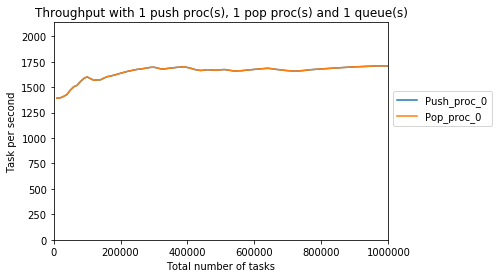

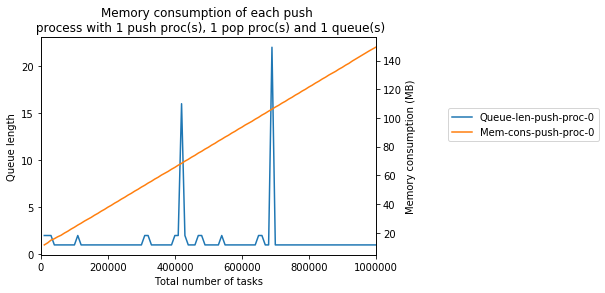

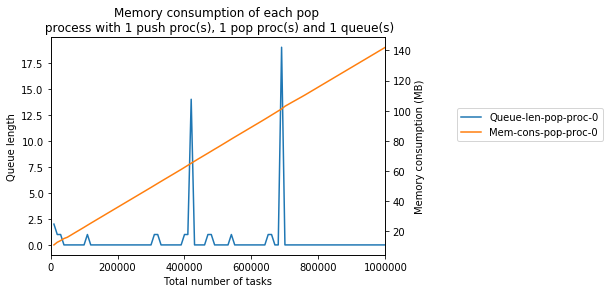

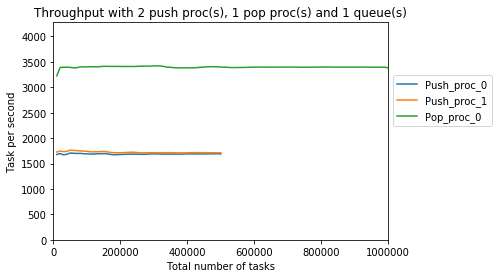

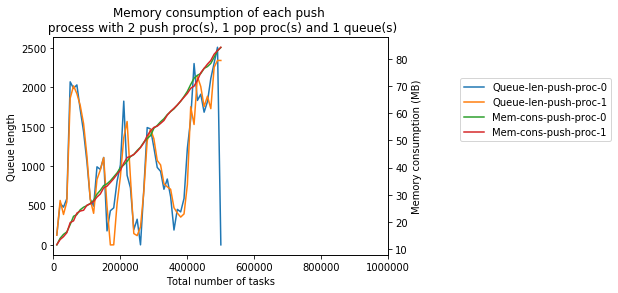

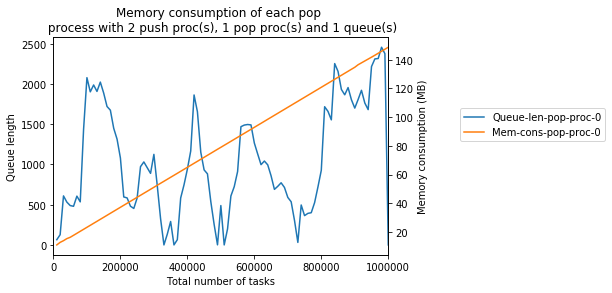

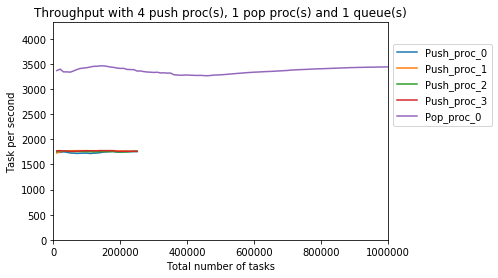

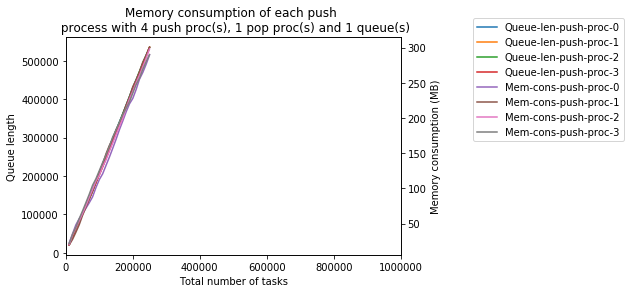

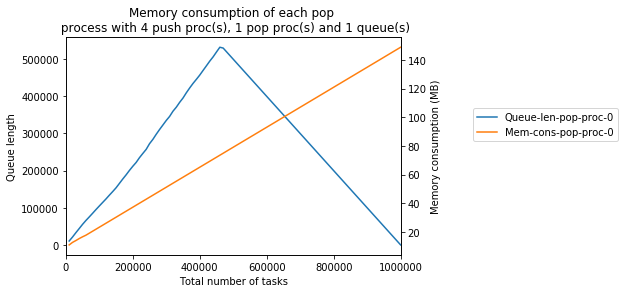

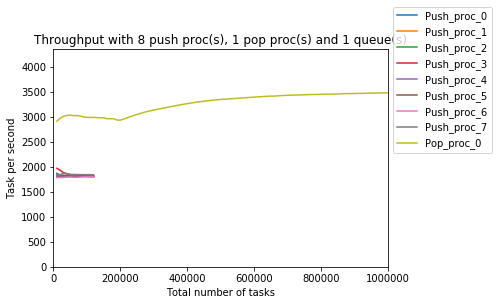

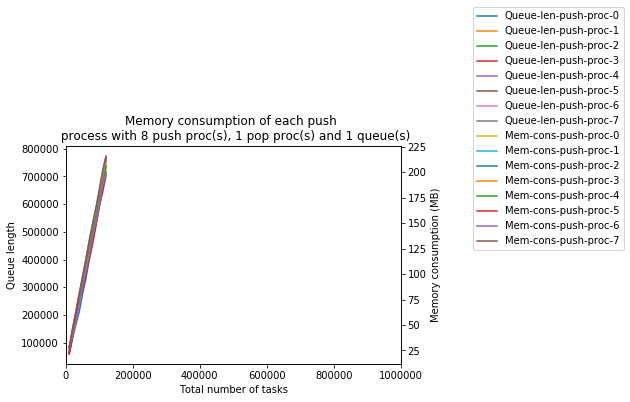

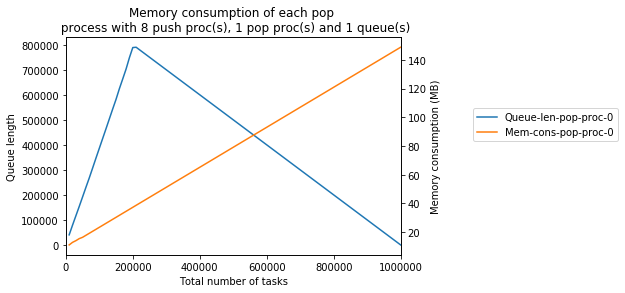

In [103]:
num_push_procs_list = [1,2,4,8]
num_pop_procs = 1
num_queues = 1
num_samples = 100

for num_push_procs in num_push_procs_list:
    get_throughput_plot(num_push_procs, num_pop_procs, num_queues, num_samples)
    get_queue_push_plot(num_push_procs, num_pop_procs, num_queues, num_samples)
    get_queue_pop_plot(num_push_procs, num_pop_procs, num_queues, num_samples)

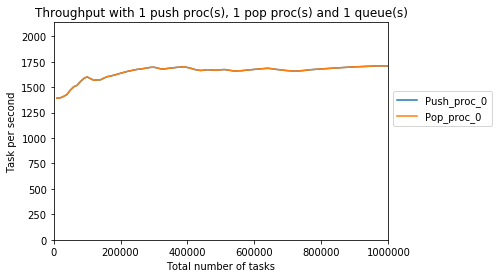

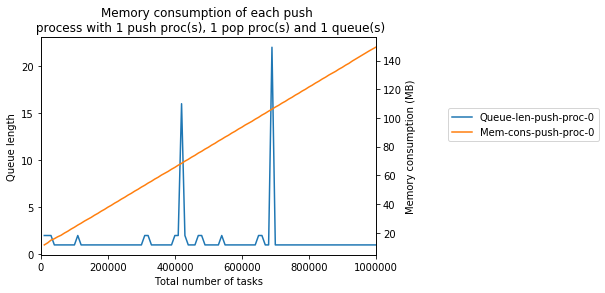

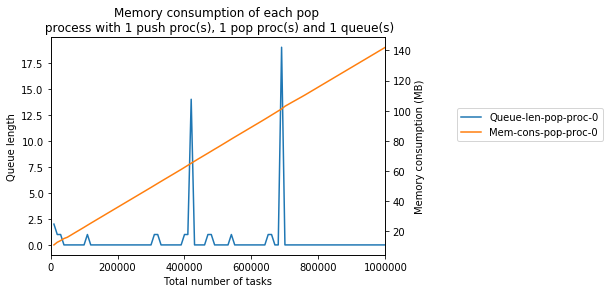

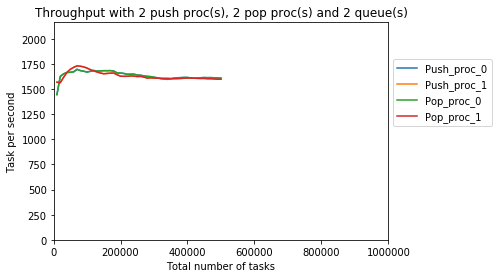

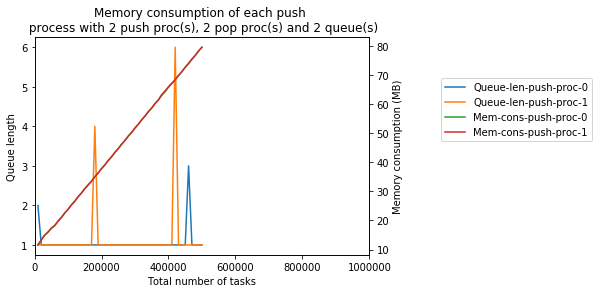

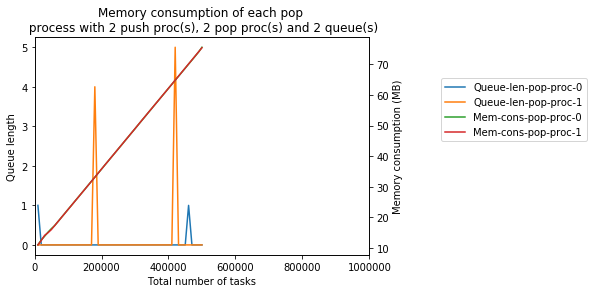

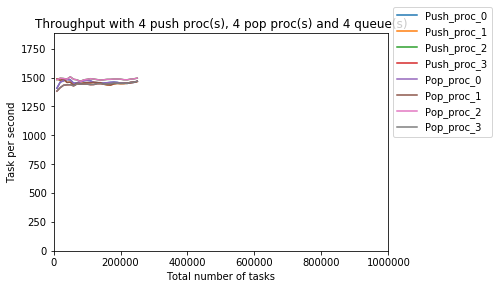

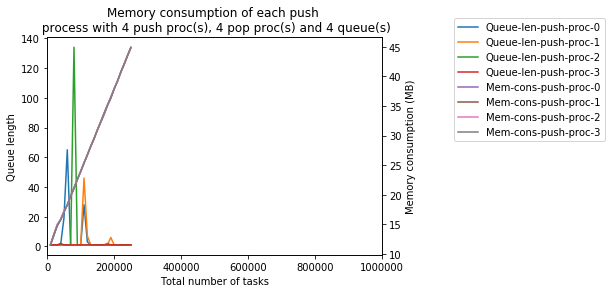

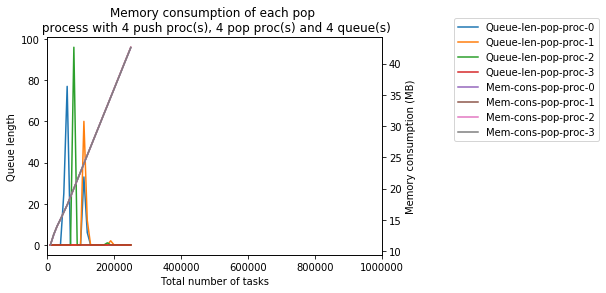

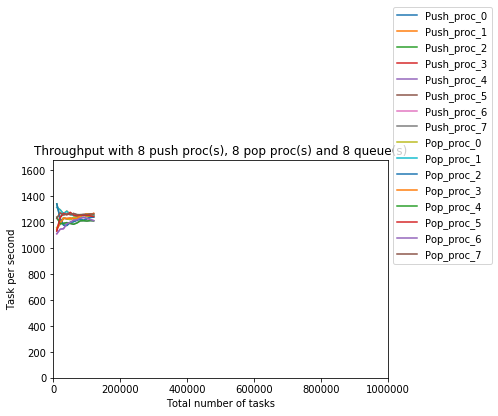

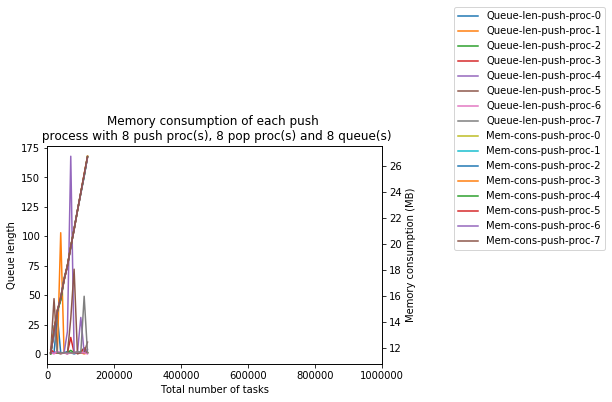

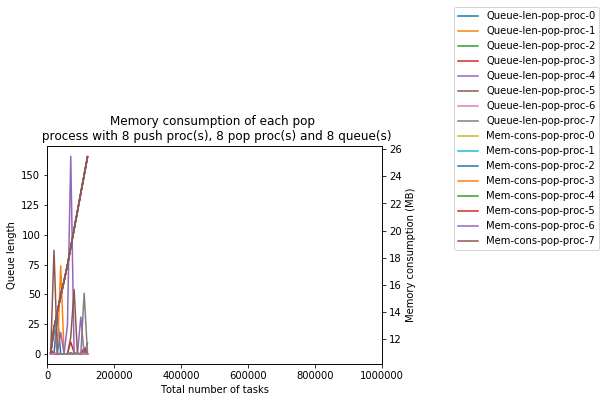

In [104]:
num_queues_list = [1,2,4,8]
num_samples = 100

for num_queues in num_queues_list:
    num_push_procs= num_queues
    num_pop_procs= num_queues
    get_throughput_plot(num_push_procs, num_pop_procs, num_queues, num_samples)
    get_queue_push_plot(num_push_procs, num_pop_procs, num_queues, num_samples)
    get_queue_pop_plot(num_push_procs, num_pop_procs, num_queues, num_samples)

In [173]:
import numpy as np

def fill_timing_data(df, df_err, num_push_procs, num_pop_procs, num_queues):
    
    time_taken_push_procs =  [0.0 for _ in range(3)]
    time_taken_pop_procs =  [0.0 for _ in range(3)]    
    ttc = [0.0 for _ in range(3)]
    mem_cons = [0.0 for _ in range(3)]
        
    for i in range(3):
    
        DATA = './data_19_Apr/push_%s_pop_%s_q_%s_trial_%s'%(num_push_procs, num_pop_procs, num_queues,i)
    
        push_data = glob.glob('%s/push*.txt'%DATA)
    
        min_push = 0.0
        max_push = 0.0
    
        for f1 in push_data:
        
            f = open(f1,'r')        
            lines = f.readlines()
            f.close()
        
            for line in lines:
            
                cur_time = float(line.strip().split(' ')[0].strip())
            
                if min_push == 0.0:
                    min_push = cur_time
                    max_push = cur_time
                
                if cur_time < min_push:
                    min_push = cur_time
                    
                if cur_time > max_push:
                    max_push = cur_time
    
    
        pop_data = glob.glob('%s/pop*.txt'%DATA)
        
        min_pop = 0.0
        max_pop = 0.0
    
        for f1 in pop_data:
        
            f = open(f1,'r')        
            lines = f.readlines()
            f.close()
        
            for line in lines:
            
                cur_time = float(line.strip().split(' ')[0].strip())
            
                if min_pop == 0.0:
                    min_pop = cur_time
                    max_pop = cur_time
                
                if cur_time < min_pop:
                    min_pop = cur_time
                if cur_time > max_pop:
                    max_pop = cur_time
                
        time_taken_push_procs[i] =  max_push - min_push
        time_taken_pop_procs[i] =  max_pop - min_pop    
        ttc[i] = max(max_pop,max_push) - min(min_pop, min_push)
        
    vals = [np.mean(time_taken_push_procs), 
            np.mean(time_taken_pop_procs),
            np.mean(ttc)]
    
    #print df.loc['%s,%s,%s'%(num_push_procs, num_pop_procs, num_queues)]
    df.loc['%s,%s,%s'%(num_push_procs, num_pop_procs, num_queues)] = vals
    
    vals = [np.std(time_taken_push_procs), 
            np.std(time_taken_pop_procs),
            np.std(ttc)]
    
    df_err.loc['%s,%s,%s'%(num_push_procs, num_pop_procs, num_queues)] = vals
    
    return df, df_err

In [175]:
#TTC
num_push_procs_list = [1,2,4,8]
num_pop_procs = 1
num_queues = 1

cols = ['Time taken for all push procs','Time taken for all pop procs','TTC']
index = ['%s,1,1'%i for i in num_push_procs_list]
#index = []
index.extend(['%s,%s,%s'%(i,i,i) for i in num_push_procs_list[1:]])

df = pd.DataFrame(columns=cols, index=index)
df_err = pd.DataFrame(columns=cols, index=index)

for num_push_procs in num_push_procs_list:
    df, df_err = fill_timing_data(df, df_err, num_push_procs, num_pop_procs, num_queues)

for num_push_procs in num_push_procs_list:
    num_pop_procs = num_push_procs
    num_queues = num_push_procs
    df, df_err = fill_timing_data(df, df_err, num_push_procs, num_pop_procs, num_queues)

      Time taken for all push procs Time taken for all pop procs      TTC
1,1,1                        577.44                      577.437   577.44
2,1,1                        297.84                      297.837   297.84
4,1,1                       142.993                      290.457  290.457
8,1,1                       69.3833                      287.237  287.243
2,2,2                       312.367                       312.36  312.367
4,4,4                        170.98                      170.993  170.997
8,8,8                       102.523                      102.523  102.523
      Time taken for all push procs Time taken for all pop procs        TTC
1,1,1                        8.1879                      8.19248     8.1879
2,1,1                       1.91097                      1.91451    1.91097
4,1,1                      0.596899                     0.777875   0.777875
8,1,1                      0.105304                     0.463345   0.458863
2,2,2                       

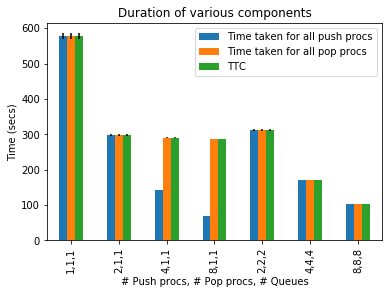

In [176]:
print df
print df_err
ax = df.plot(kind='bar', yerr=df_err, title='Duration of various components', use_index = True)

ax.set_xlabel('# Push procs, # Pop procs, # Queues')
ax.set_ylabel('Time (secs)')